
# SSVEP Visualization

This example demonstrates loading, organizing, and visualizing data from the steady-state visual evoked potentials (SSVEP) experiment. 

The data used is the first subject and first session of the one of the eeg-expy ssvep example datasets, recorded using the InteraXon MUSE EEG headset (2016 model). This session consists of six two-minute blocks of continuous recording.  

We first use the `fetch_datasets` to obtain a list of filenames. If these files are not already present 
in the specified data directory, they will be quickly downloaded from the cloud. 

After loading the data, we place it in an MNE `Epochs` object, and obtain the trial-averaged response. 

The final figures show the visual frequencies appearing in the measured power spectrum. 


In [1]:
# Some standard pythonic imports
import os, numpy as np, pandas as pd
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.time_frequency import tfr_morlet

# EEG-Notebooks functions
from eegnb.analysis.analysis_utils import load_data,plot_conditions
from eegnb.datasets import fetch_dataset

Load Data
 ---------------------

 We will use the eeg-expy SSVEP example dataset

 Note that if you are running this locally, the following cell will download
 the example dataset, if you do not already have it.

##################################################################################################



In [2]:
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    
ssvep_data_path = os.path.join(eegnb_data_path, 'visual-SSVEP', 'eegnb_examples')

# If dataset hasn't been downloaded yet, download it 
if not os.path.isdir(ssvep_data_path):
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-SSVEP', site='eegnb_examples');        


subject = 1
session = 1
raw = load_data(subject, session, 
                experiment='visual-SSVEP', site='eegnb_examples', device_name='muse2016',
                data_dir = eegnb_data_path,
                replace_ch_names={'Right AUX': 'POz'})
raw.set_channel_types({'POz': 'eeg'})

Downloading...
From: https://drive.google.com/uc?id=1zj9Wx-YEMJo7GugUUu7Sshcybfsr-Fze
To: C:\Users\pavit\.eegnb\data\downloaded_data.zip
100%|██████████| 5.14M/5.14M [00:01<00:00, 3.89MB/s]




Loading these files: 

C:\Users\pavit\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.20.04.csv

C:\Users\pavit\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.22.51.csv

C:\Users\pavit\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.25.17.csv

C:\Users\pavit\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.27.36.csv

C:\Users\pavit\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.29.57.csv

C:\Users\pavit\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.32.15.csv




['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'POz', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'st

<RawArray | 6 x 184368 (720.2 s), ~8.5 MiB, data loaded>

## Visualize the power spectrum



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


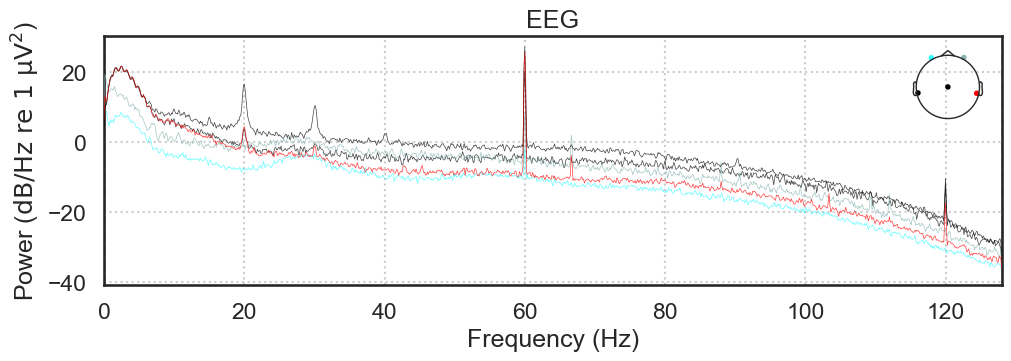

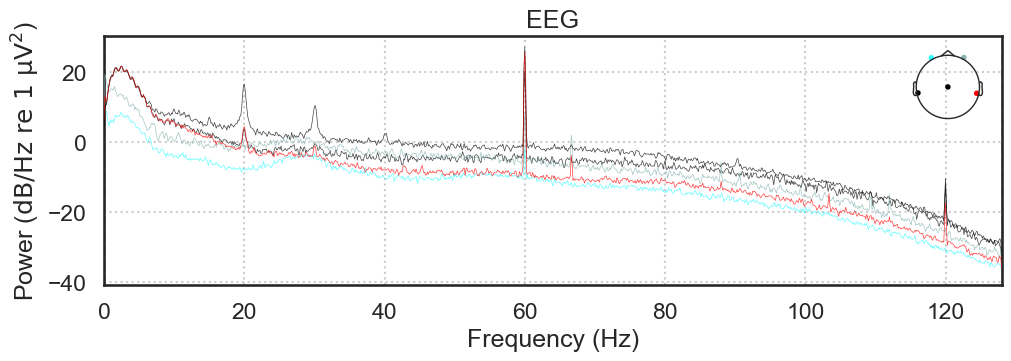

In [3]:
raw.plot_psd()

## Epoching



In [4]:
# Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus.
# Note: we will not reject epochs here because the amplitude of the SSVEP at POz is so large it is difficult to separate from eye blinks

events = find_events(raw)
event_id = {'30 Hz': 1, '20 Hz': 2}
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.5, tmax=4, baseline=None, preload=True,
                verbose=False, picks=[0, 1, 2, 3, 4])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

Finding events on: stim
197 events found on stim channel stim
Event IDs: [1 2]
sample drop %:  2.538071065989844


## Stimuli-Specific PSD



Effective window size : 4.016 (s)
Effective window size : 4.016 (s)


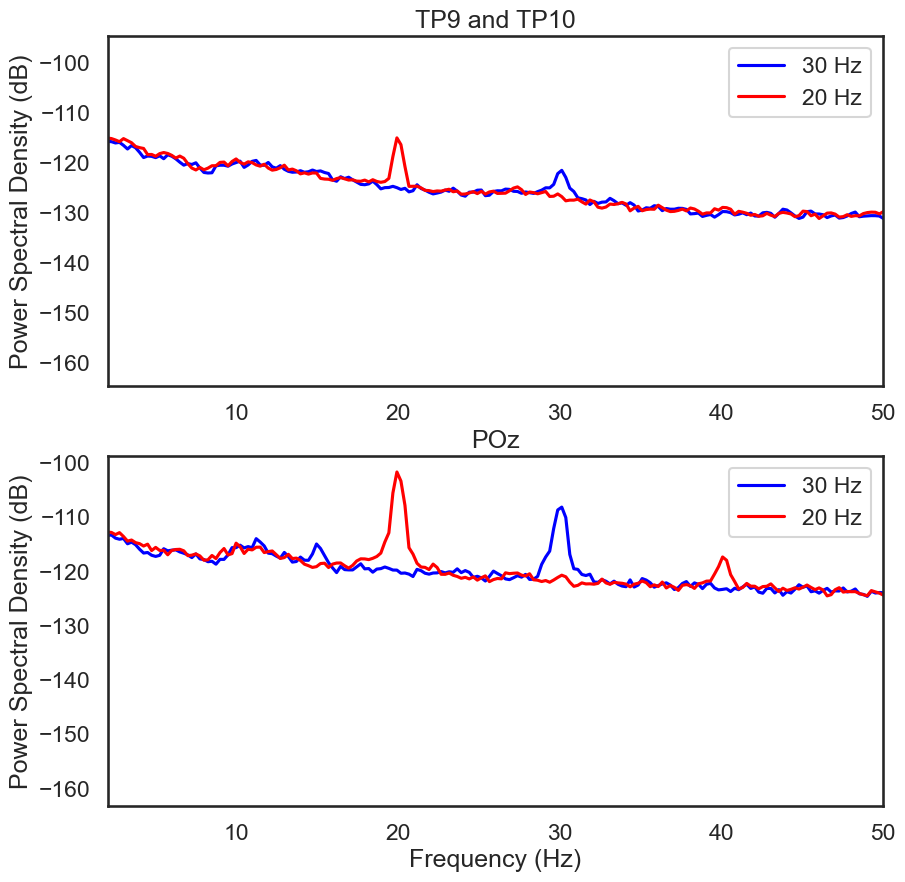

In [5]:
# Next, we can compare the PSD of epochs specifically during 20hz and 30hz stimulus presentation

f, axs = plt.subplots(2, 1, figsize=(10, 10))

welch_params=dict(method='welch',
                  n_fft=1028,
                  n_per_seg=256 * 3,
                  picks='all')

psd1, freq1 = epochs['30 Hz'].compute_psd(**welch_params).get_data(return_freqs=True)
psd2, freq2 = epochs['20 Hz'].compute_psd(**welch_params).get_data(return_freqs=True)
psd1 = 10 * np.log10(psd1)
psd2 = 10 * np.log10(psd2)

psd1_mean = psd1.mean(0)
psd1_std = psd1.mean(0)

psd2_mean = psd2.mean(0)
psd2_std = psd2.mean(0)

axs[0].plot(freq1, psd1_mean[[0, 3], :].mean(0), color='b', label='30 Hz')
axs[0].plot(freq2, psd2_mean[[0, 3], :].mean(0), color='r', label='20 Hz')

axs[1].plot(freq1, psd1_mean[4, :], color='b', label='30 Hz')
axs[1].plot(freq2, psd2_mean[4, :], color='r', label='20 Hz')

axs[0].set_title('TP9 and TP10')
axs[1].set_title('POz')

axs[0].set_ylabel('Power Spectral Density (dB)')
axs[1].set_ylabel('Power Spectral Density (dB)')

axs[0].set_xlim((2, 50))
axs[1].set_xlim((2, 50))

axs[1].set_xlabel('Frequency (Hz)')

axs[0].legend()
axs[1].legend()

plt.show();

# With this visualization we can clearly see distinct peaks at 30hz and 20hz in the PSD, corresponding to the frequency of the visual stimulation. The peaks are much larger at the POz electrode, but still visible at TP9 and TP10

## Spectrogram



NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


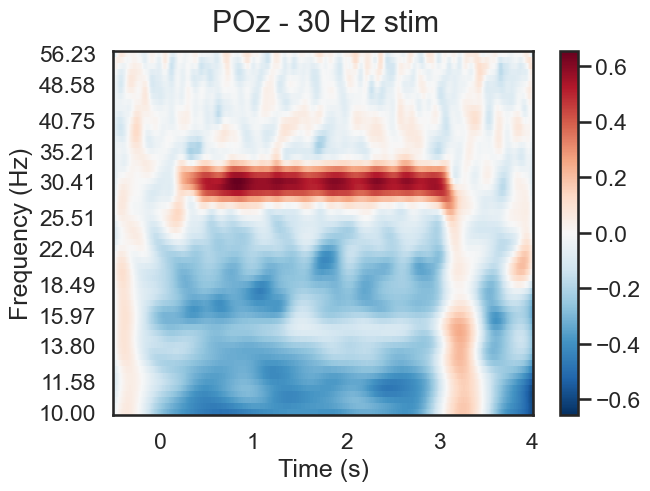

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


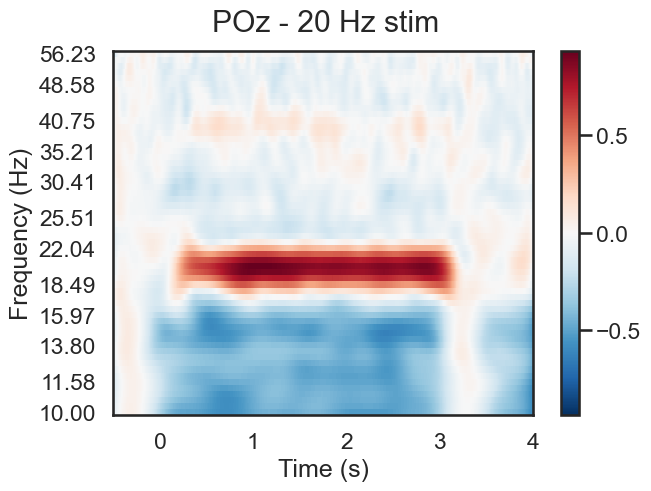

<Figure size 640x480 with 0 Axes>

In [6]:
# We can also look for SSVEPs in the spectrogram, which uses color to represent the power of frequencies in the EEG signal over time

frequencies = np.logspace(1, 1.75, 60)
tfr, itc = tfr_morlet(epochs['30 Hz'], freqs=frequencies,picks='all',
                              n_cycles=15, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
                 title='POz - 30 Hz stim');

tfr, itc = tfr_morlet(epochs['20 Hz'], freqs=frequencies,picks='all',
                              n_cycles=15, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
                 title='POz - 20 Hz stim');

# Set Layout engine to tight to fix error with using colorbar layout error
plt.figure().set_layout_engine('tight');
plt.tight_layout()
plt.show()

# Once again we can see clear SSVEPs at 30hz and 20hz